In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required by wpod-net
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
# from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from sklearn.preprocessing import LabelEncoder
import glob

In [3]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [4]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


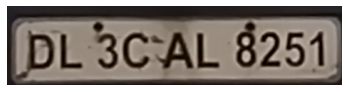

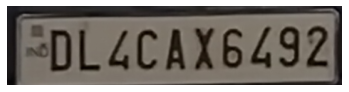

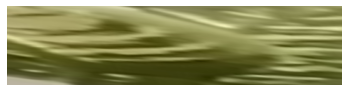

In [4]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

# test_image_path = "Plate_examples/india_multi_car.jpg"
# vehicle, LpImg,cor = get_plate(test_image_path)

# for i in range(len(LpImg)):
#     fig = plt.figure(figsize=(6,6))
# #     grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# #     fig.add_subplot(grid[0])
# #     plt.axis(False)
# #     plt.imshow(vehicle)
#     grid = gridspec.GridSpec(ncols=1,nrows=1,figure=fig)
#     fig.add_subplot(grid[0])
#     plt.axis(False)
#     plt.imshow(LpImg[i])
#     plt.savefig("lp{}.png".format(i))

In [11]:
from imageio import imwrite
print(LpImg[0].shape)
print(type(LpImg[0]))
# im = Image.fromarray(LpImg[0]).convert("RGB")
imwrite('lp.jpeg', LpImg[0])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(110, 470, 3)
<class 'numpy.ndarray'>


In [12]:
#NANONETS
# model_id = os.environ.get('NANONETS_MODEL_ID')
# api_key = os.environ.get('NANONETS_API_KEY')
import requests
model_id = "7ed7a301-a1f4-4569-a64e-ada51a943af3"
api_key = "8L-9tbv6fKmyptHc8ZJ9DYDv8loZwYyw"
# image_path = sys.argv[1]

url = 'https://app.nanonets.com/api/v2/ObjectDetection/Model/' + model_id + '/LabelFile/'

# open(image_path, 'rb')
# for i in LpImg:
data = {'file': open('plates/LP14.png', 'rb'),    'modelId': ('', model_id)}

response = requests.post(url, auth=requests.auth.HTTPBasicAuth(api_key, ''), files=data)

print(response.text)

{"message":"Success","result":[{"message":"Success","input":"LP14.png","prediction":[{"id":"","label":"number_plate","xmin":56,"ymin":28,"xmax":449,"ymax":85,"score":0.9971924,"ocr_text":"DL 7 CR 8288"}],"page":0,"request_file_id":"2f2b4bec-827c-4fd2-a700-2787f32047e5","filepath":"uploadedfiles/7ed7a301-a1f4-4569-a64e-ada51a943af3/PredictionImages/1682592541.jpeg","id":"2541dd1a-d9c3-11eb-aa75-ce1a32e3040a","rotation":0}],"signed_urls":{"uploadedfiles/7ed7a301-a1f4-4569-a64e-ada51a943af3/PredictionImages/1682592541.jpeg":{"original":"https://nnts.imgix.net/uploadedfiles/7ed7a301-a1f4-4569-a64e-ada51a943af3/PredictionImages/1682592541.jpeg?expires=1625086179\u0026or=0\u0026s=646b34d9b594b69fd472d2a39208ef98","original_compressed":"https://nnts.imgix.net/uploadedfiles/7ed7a301-a1f4-4569-a64e-ada51a943af3/PredictionImages/1682592541.jpeg?auto=compress\u0026expires=1625086179\u0026or=0\u0026s=b5851c9d0b1f86d4a8641baa4b104d27","thumbnail":"https://nnts.imgix.net/uploadedfiles/7ed7a301-a1f4-

In [19]:
import json
y = json.loads(response.text)

In [26]:
print(y['result'][0]['prediction'][0]['ocr_text'])

DL 7 CR 8288


In [30]:
import os.path
for i in os.listdir("plates/"):
    data = {'file': open(os.path.join("plates/",i), 'rb'),    'modelId': ('', model_id)}
    response = requests.post(url, auth=requests.auth.HTTPBasicAuth(api_key, ''), files=data)
    try:
        y = json.loads(response.text)
        print(f"{i}: ",y['result'][0]['prediction'][0]['ocr_text'])
    except:
        print("Error: {}".format(i))


LP12.png:  DL 1CN 8726 IND
LP41.png:  DL 7CT 7657-
LP1.png:  DL2CBB7335
LP7.png:  -DL 7CT 7657-
LP18.png:  OL 2CBB546O
LP3.png:  GLICAZ0152
LP5.png:  DL 5C0 3357 IND
LP23.png:  DL 7CT 7657-
LP13.png:  DL3C BV 4770
LP8.png:  DL2CBB7335
LP38.png:  DL 7CT 7657-
LP2.png:  FOL 7CT 7657-


KeyboardInterrupt: 

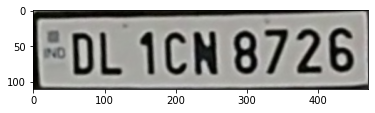

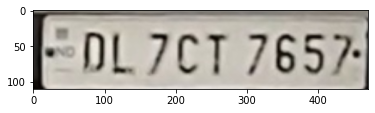

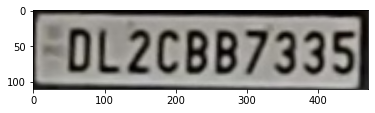

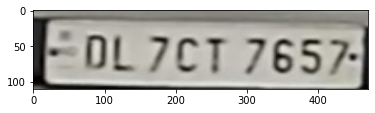

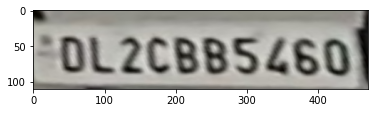

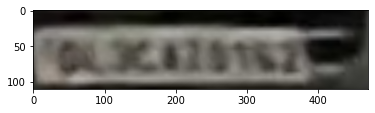

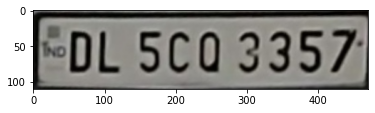

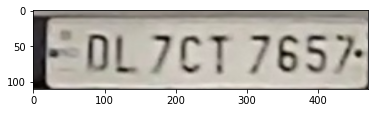

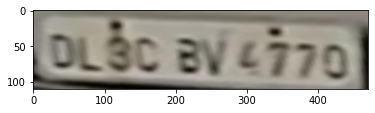

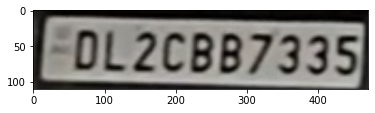

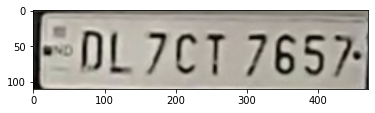

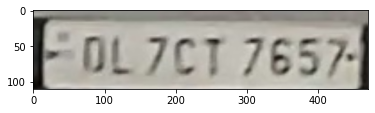

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
lst = ["plates/LP12.png", "plates/LP41.png", "plates/LP1.png", "plates/LP7.png",
      "plates/LP18.png", "plates/LP3.png", "plates/LP5.png", "plates/LP23.png", "plates/LP13.png", "plates/LP8.png",
      "plates/LP38.png", "plates/LP2.png"]
for i in lst:
    img = mpimg.imread(i)
    imgplot = plt.imshow(img)
    plt.show()